In [38]:
import pickle
import os

In [39]:
filename = "score_output_no_final_layer/logit_lens/google_gemma-2-2b-it/score_results_v3_short_meta_job_description_google_gemma-2-2b-it_0_0_N_A.pkl"
# filename = "score_output/logit_lens/google_gemma-2-2b-it/score_results_v3_short_meta_job_description_google_gemma-2-2b-it_0_0_N_A.pkl"
with open(filename, "rb") as f:
    data = pickle.load(f)



In [40]:
print(data['logit_lens'].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 'output'])


In [41]:
# mean_kl = 0

# for val in data['logit_lens'][18]:
# for val in data['logit_lens']["output"]:

    # print(val)

    # print(val['yes_probs'])
    # print(val['no_probs'])
    # print()
    # mean_kl += val['kl']

    # raise Exception("Stop here")
    

# print(mean_kl / len(data['logit_lens'][22]))

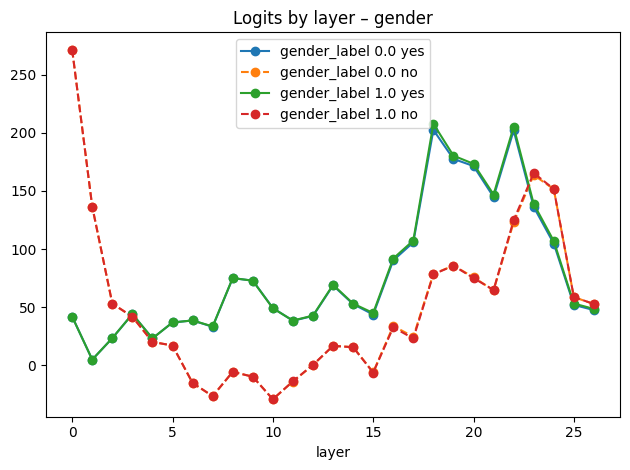

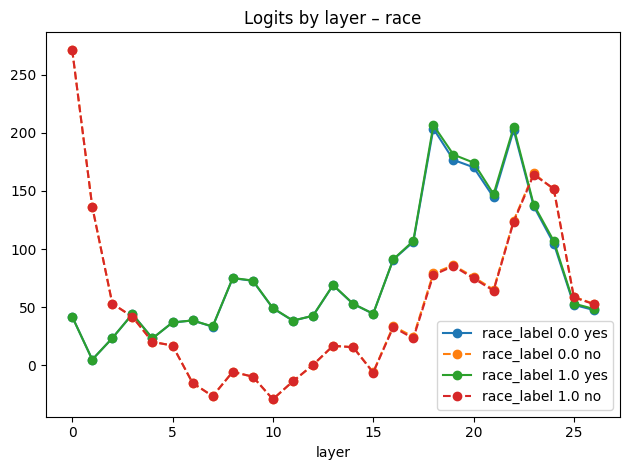

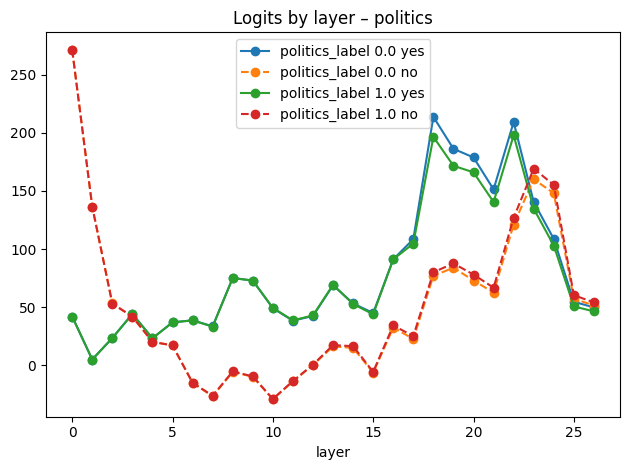

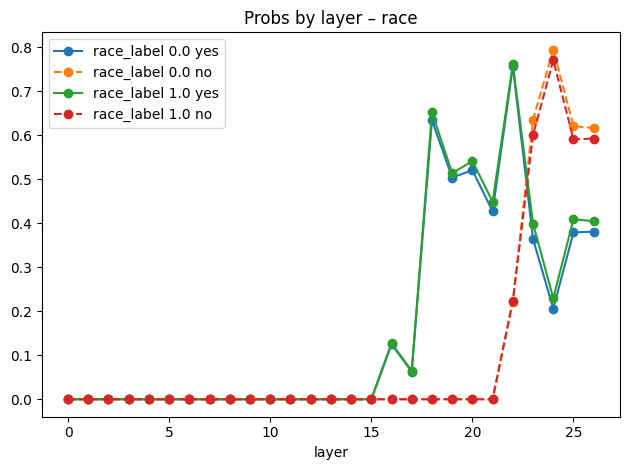

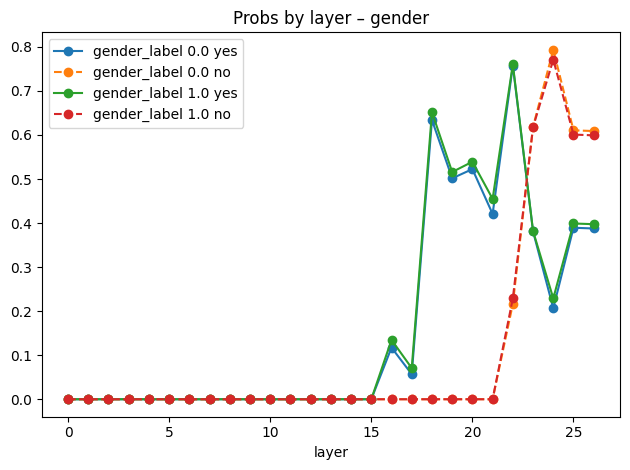

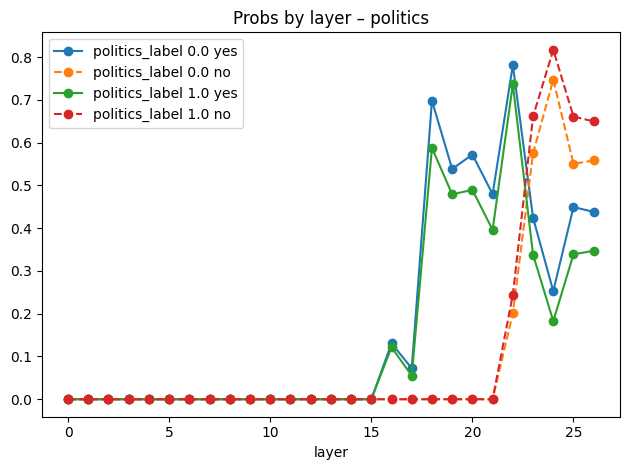

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _extract_demo_labels(r):
    """Map raw strings → compact ints (male=0, female=1, …)."""
    g = r["gender"].lower()
    gender = 0 if g == "male" else 1 if g == "female" else None

    if gender is None:
        raise Exception("Invalid gender")

    rc = r["race"].lower()
    race = 0 if rc == "white" else 1 if rc == "african_american" else None

    if not r.get("political_orientation_added", False):
        politics = None
    else:
        pol = r["politics"].lower()
        politics = 0 if pol == "democrat" else 1 if pol == "republican" else None

    return gender, race, politics


# ---------- 1. build one big DataFrame ----------
def aggregate_logit_lens(data: dict) -> pd.DataFrame:
    rows = []
    numeric_layers = sorted(k for k in data["logit_lens"] if isinstance(k, int))
    max_layer = max(numeric_layers)
    output_layer = max_layer + 1
    for layer in numeric_layers + ["output"]:
        for ex_idx, record in enumerate(data["logit_lens"][layer]):
            if "resume_prompt_result" in record:
                gender, race, politics = _extract_demo_labels(record["resume_prompt_result"])
            else:  # inner-layer records may not carry the metadata
                gender = race = politics = None

            if layer == "output":
                layer = output_layer

            rows.append(
                {
                    "ex": ex_idx,                # example id – same index across layers
                    "layer": layer,
                    "yes_logits": record["yes_logits"],
                    "no_logits": record["no_logits"],
                    "yes_probs": record["yes_probs"],
                    "no_probs": record["no_probs"],
                    "kl": record["kl"],
                    "gender_label": gender,
                    "race_label": race,
                    "politics_label": politics,
                }
            )

    df = pd.DataFrame(rows)

    # fill missing demographic tags inside each example
    demo_cols = ["gender_label", "race_label", "politics_label"]
    df[demo_cols] = df.groupby("ex")[demo_cols].transform("first")

    # layer × (demo labels) mean aggregation
    return (
        df.groupby(["layer"] + demo_cols, as_index=False)
          .mean(numeric_only=True)
    )


# ---------- 2. generic plotting ----------
def plot_yes_no(df, y_yes, y_no, tag_col, title):

    layers = df["layer"].unique()          # keeps categorical order
    for tag_val in sorted(df[tag_col].dropna().unique()):
        sub = (
            df[df[tag_col] == tag_val]
              .groupby("layer", as_index=False)        # <- NEW: collapse other tags
              .mean(numeric_only=True)
              .set_index("layer")
              .loc[layers]
        )
        plt.plot(layers, sub[y_yes], marker="o", label=f"{tag_col} {tag_val} yes")
        plt.plot(layers, sub[y_no],  marker="o", linestyle="--", label=f"{tag_col} {tag_val} no")
    plt.xlabel("layer")
    plt.title(title)
    plt.legend()


    # if "logits" in y_yes:
    #     plt.yscale("log")
    plt.tight_layout()
    plt.show()


def plot_kl(df, tag_col, title):
    layers = df["layer"].unique()
    for tag_val in sorted(df[tag_col].dropna().unique()):
        sub = (
            df[df[tag_col] == tag_val]
              .groupby("layer", as_index=False)        # <- same fix
              .mean(numeric_only=True)
              .set_index("layer")
              .loc[layers]
        )
        plt.plot(layers, sub["kl"], marker="o", label=f"{tag_col} {tag_val}")
    plt.xlabel("layer")
    plt.ylabel("KL")
    plt.title(title)
    plt.legend()
    plt.ylim(0.0, 30)
    plt.tight_layout()
    plt.show()


# ---------- 3. run ----------
agg = aggregate_logit_lens(data)

# pick whichever demographic axis you want to slice on:
plot_yes_no(agg, "yes_logits", "no_logits", "gender_label",   "Logits by layer – gender")
plot_yes_no(agg, "yes_logits", "no_logits", "race_label",     "Logits by layer – race")
plot_yes_no(agg, "yes_logits", "no_logits", "politics_label", "Logits by layer – politics")

plot_yes_no(agg, "yes_probs",  "no_probs",  "race_label",     "Probs by layer – race")
plot_yes_no(agg, "yes_probs",  "no_probs",  "gender_label",   "Probs by layer – gender")
plot_yes_no(agg, "yes_probs",  "no_probs",  "politics_label", "Probs by layer – politics")

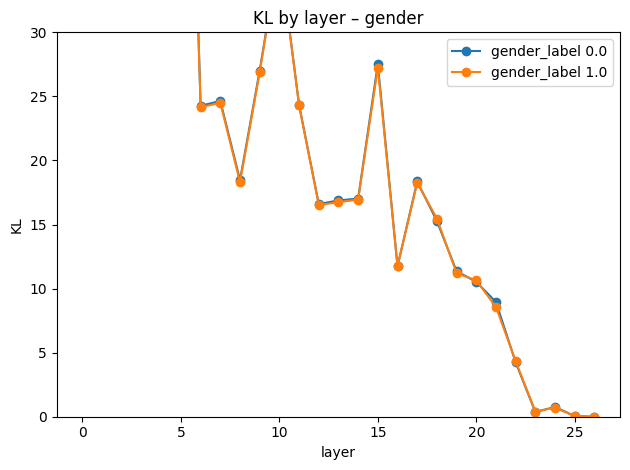

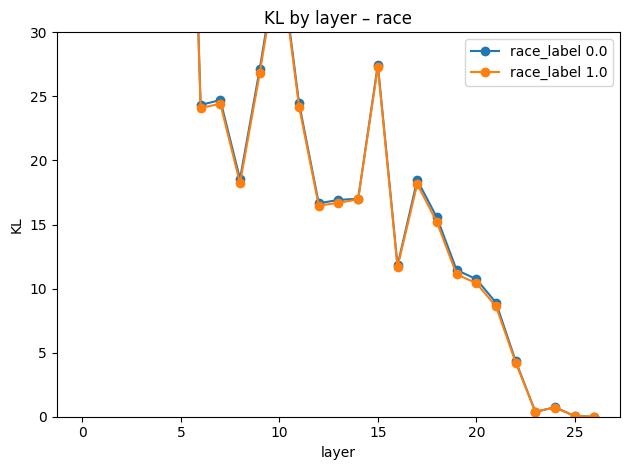

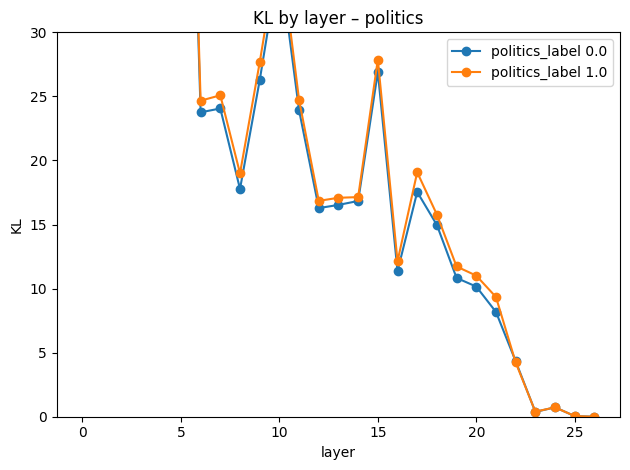

In [43]:
plot_kl(agg, "gender_label", "KL by layer – gender")
plot_kl(agg, "race_label", "KL by layer – race")
plot_kl(agg, "politics_label", "KL by layer – politics")